<a href="https://colab.research.google.com/github/vuiseng9/d-playground/blob/main/Stable_Diffusion_based_lossy_image_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion for lossy image compression
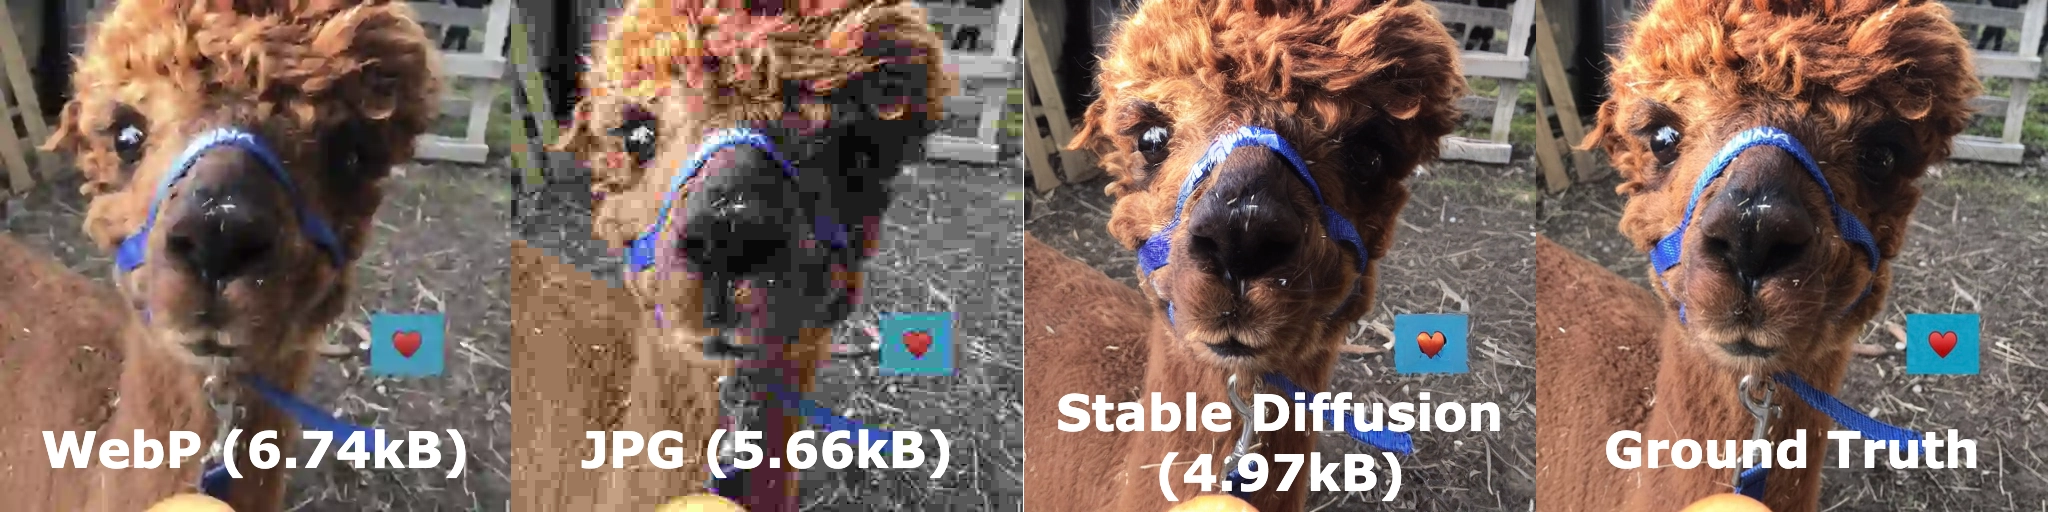

# Import Libraries

You may need to restart the runtime after executing this cell since PIL is updated

In [ ]:
!pip install -qq diffusers["training"] transformers ftfy
!pip install -qq libimagequant
!pip install -qq mozjpeg-lossless-optimization
!pip install -qq scikit-image
!pip install Pillow -U

#Important

if PIL was updated, you have to restart the runtime after running this cell the first time. Click on 'Restart Runtime' above. Without restarting, you'll get a runtime error about PIL further down.

#Settings

In [ ]:
input_folder = '/content/drive/MyDrive/compression_test/input/' #@param {type:"string"}
output_folder = '/content/drive/MyDrive/compression_test/output/' #@param {type:"string"}
huggingface_token = '' #@param {type:"string"}
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#Connecting Google Drive

To load test images for compression, connect to your Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Connect to Huggingface and download Stable Diffusion model

In order to download the Stable Diffusion model, you have to create a free account on the huggingface.com website and then create an access token here: https://huggingface.co/settings/tokens

After that, copy the access token to the field of the settings cell.

Additionally, you also have to accept the Stable Diffusion usage license by accepting it here: https://huggingface.co/CompVis/stable-diffusion-v1-4

Otherwise the following Cell will fail

In [ ]:
from huggingface_hub import notebook_login
!echo $huggingface_token | huggingface-cli login


from diffusers import AutoencoderKL, UNet2DConditionModel, UNet2DModel, StableDiffusionImg2ImgPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
import torch
from torch.cuda.amp import autocast

#torch_device = "cpu"
torch_device = "cuda"

vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae", use_auth_token=True
).to(torch_device)

unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", use_auth_token=True
).to(torch_device)

scheduler = PNDMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",
    num_train_timesteps=1000, skip_prk_steps=True
).set_format("pt")

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", use_auth_token=True,
)

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    use_auth_token=True,
    #revision=pretrained_model_revision, torch_dtype=torch.float16
)

uncond_input = tokenizer([""], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids)[0].to(torch_device)

#Define helper methods

In [ ]:
import PIL
from PIL import Image
import numpy as np
import inspect
import io
import libimagequant as liq
import zlib
import gc
import time
import mozjpeg_lossless_optimization
from skimage.metrics import structural_similarity as get_ssim
from skimage.metrics import peak_signal_noise_ratio as get_psnr

@torch.no_grad()
def to_latents(img:Image):
  np_img = (np.array(img).astype(np.float32) / 255.0) * 2.0 - 1.0
  np_img = np_img[None].transpose(0, 3, 1, 2)
  torch_img = torch.from_numpy(np_img)
  with autocast():
    generator = torch.Generator("cuda").manual_seed(0)
    latents = vae.encode(torch_img.to(vae.dtype).to(torch_device)).latent_dist.sample(generator=generator)
  return latents

@torch.no_grad()
def to_img(latents):
  with autocast():
    torch_img = vae.decode(latents.to(vae.dtype).to(torch_device)).sample
  torch_img = (torch_img / 2 + 0.5).clamp(0, 1)
  np_img = torch_img.cpu().permute(0, 2, 3, 1).detach().numpy()[0]
  np_img = (np_img * 255.0).astype(np.uint8)
  img = Image.fromarray(np_img)
  return img

def resize_to_512(input_file, output_file):
  img = Image.open(input_file).convert('RGB')
  #center crop image
  maxdim = max(img.width, img.height)
  mindim = min(img.width, img.height)
  left = max(0, (img.width - img.height) // 2 - 1)
  top = max(0, (img.height - img.width) // 2 - 1)
  img = img.crop((left, top, left + mindim - 1, top + mindim - 1))
  #resize
  img = img.resize((512,512), Image.LANCZOS)
  img.save(output_file, lossless = True, quality = 100)

def print_metrics(gt, img):
  gt = np.array(gt)
  img = np.array(img)
  print('PSNR: ' + str(get_psnr(gt, img)))
  print('SSIM: ' + str(get_ssim(gt, img, multichannel=True, data_range=img.max() - img.min())))

#Define compression methods



In [ ]:
def quantize(latents):
  quantized_latents = (latents / (255 * 0.18215) + 0.5).clamp(0,1)
  quantized = quantized_latents.cpu().permute(0, 2, 3, 1).detach().numpy()[0]
  quantized = (quantized * 255.0 + 0.5).astype(np.uint8)
  return quantized

def unquantize(quantized):
  unquantized = quantized.astype(np.float32) / 255.0
  unquantized = unquantized[None].transpose(0, 3, 1, 2)
  unquantized_latents = (unquantized - 0.5) * (255 * 0.18215)
  unquantized_latents = torch.from_numpy(unquantized_latents)
  return unquantized_latents.to(torch_device)

@torch.no_grad()
def denoise(latents):  
  latents = latents * 0.18215
  step_size = 15
  num_inference_steps = scheduler.config.get("num_train_timesteps", 1000) // step_size
  strength = 0.04
  scheduler.set_timesteps(num_inference_steps)
  offset = scheduler.config.get("steps_offset", 0)
  init_timestep = int(num_inference_steps * strength) + offset
  init_timestep = min(init_timestep, num_inference_steps)
  timesteps = scheduler.timesteps[-init_timestep]
  timesteps = torch.tensor([timesteps], dtype=torch.long, device=torch_device)
  extra_step_kwargs = {}
  if "eta" in set(inspect.signature(scheduler.step).parameters.keys()):
    extra_step_kwargs["eta"] = 0.9
  latents = latents.to(unet.dtype).to(torch_device)
  t_start = max(num_inference_steps - init_timestep + offset, 0)
  with autocast():
    for i, t in enumerate(scheduler.timesteps[t_start:]):
      noise_pred = unet(latents, t, encoder_hidden_states=uncond_embeddings).sample
      latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample
  #reset scheduler to free cached noise predictions
  scheduler.set_timesteps(1)
  return latents / 0.18215

def compress_input(input_file, output_path):
  gt_img = Image.open(input_file)
  display(gt_img)
  print('Ground Truth')

  # Display VAE roundtrip image
  latents = to_latents(gt_img)
  img_from_latents = to_img(latents)
  display(img_from_latents)
  print('VAE roundtrip')
  print_metrics(gt_img, img_from_latents)

  # Quantize latent representation and save as lossless webp image
  quantized = quantize(latents)
  del latents
  quantized_img = Image.fromarray(quantized)
  quantized_img.save(output_path + "_sd_quantized_latents.webp", lossless=True, quality=100)

  # Display VAE decoded image from 8-bit quantized latents
  unquantized_latents = unquantize(quantized)
  unquantized_img = to_img(unquantized_latents)
  display(unquantized_img)
  del unquantized_latents
  print('VAE decoded from 8-bit quantized latents')
  print_metrics(gt_img, unquantized_img)

  # further quantize to palette. Use libimagequant for Dithering
  attr = liq.Attr()
  attr.speed = 1
  attr.max_colors = 256
  input_image = attr.create_rgba(quantized.flatten('C').tobytes(),
                                 quantized_img.width,
                                 quantized_img.height,
                                 0)
  quantization_result = input_image.quantize(attr)
  quantization_result.dithering_level = 1.0
  # Get the quantization result
  out_pixels = quantization_result.remap_image(input_image)
  out_palette = quantization_result.get_palette()
  np_indices = np.frombuffer(out_pixels, np.uint8)
  np_palette = np.array([c for color in out_palette for c in color], dtype=np.uint8)

  sd_palettized_bytes = io.BytesIO()
  np.savez_compressed(sd_palettized_bytes, w=64, h=64, i=np_indices.flatten(), p=np_palette)
  with open(output_path + ".npz", "wb") as f:
    f.write(sd_palettized_bytes.getbuffer())
  
  # Compress the dithered 8-bit latents using zlib and save them to disk
  compressed_bytes = zlib.compress(
      np.concatenate((np_palette, np_indices), dtype=np.uint8).tobytes(),
      level=9
      )
  with open(output_path + ".bin", "wb") as f:
    f.write(compressed_bytes)
  sd_bytes = len(compressed_bytes)

  # Display VAE decoding of dithered 8-bit latents
  np_indices = np_indices.reshape((64,64))
  palettized_latent_img = Image.fromarray(np_indices, mode='P')
  palettized_latent_img.putpalette(np_palette, rawmode='RGBA')
  latents = np.array(palettized_latent_img.convert('RGBA'))
  latents = unquantize(latents)
  palettized_img = to_img(latents)
  display(palettized_img)
  print('VAE decoding of palettized and dithered 8-bit latents')
  print_metrics(gt_img, palettized_img)

  # Use Stable Diffusion U-Net to de-noise the dithered latents
  latents = denoise(latents)
  denoised_img = to_img(latents)
  display(denoised_img)
  del latents
  print('VAE decoding of de-noised dithered 8-bit latents')
  print('size: {}b = {}kB'.format(sd_bytes, sd_bytes/1024.0))
  print_metrics(gt_img, denoised_img)

  # Find JPG compression settings that result in closest data size that is larger than SD compressed data
  jpg_bytes = io.BytesIO()
  q = 0
  while jpg_bytes.getbuffer().nbytes < sd_bytes:
    jpg_bytes = io.BytesIO()
    gt_img.save(jpg_bytes, format="JPEG", quality=q, optimize=True, subsampling=1)
    jpg_bytes.flush()
    jpg_bytes.seek(0)
    jpg_bytes = io.BytesIO(mozjpeg_lossless_optimization.optimize(jpg_bytes.read()))
    jpg_bytes.flush()
    q += 1

  with open(output_path + ".jpg", "wb") as f:
    f.write(jpg_bytes.getbuffer())
  jpg = Image.open(jpg_bytes)
  try:
    display(jpg)
    print('JPG compressed with quality setting: {}'.format(q))
    print('size: {}b = {}kB'.format(jpg_bytes.getbuffer().nbytes, jpg_bytes.getbuffer().nbytes / 1024.0))
    print_metrics(gt_img, jpg)
  except:
    print('something went wrong compressing {}.jpg'.format(output_path))

  webp_bytes = io.BytesIO()
  q = 0
  while webp_bytes.getbuffer().nbytes < sd_bytes:
    webp_bytes = io.BytesIO()
    gt_img.save(webp_bytes, format="WEBP", quality=q, method=6)
    webp_bytes.flush()
    q += 1

  with open(output_path + ".webp", "wb") as f:
    f.write(webp_bytes.getbuffer())
  try:
    webp = Image.open(webp_bytes)
    display(webp)
    print('WebP compressed with quality setting: {}'.format(q))
    print('size: {}b = {}kB'.format(webp_bytes.getbuffer().nbytes, webp_bytes.getbuffer().nbytes / 1024.0))
    print_metrics(gt_img, webp)
  except:
    print('something went wrong compressing {}.webp'.format(output_path))

# Loop over images in input folder, resize them to 512x512 and then compress

create a folder named 'compression_test' in the root of your google drive and inside compression_test a folder named 'input'. Put a few JPG and PNG test images into the input folder and then run the following cell, which will create an output folder as well as displaying the compression results

In [ ]:
import os
import shutil
import time
from tqdm import tqdm

rescaled_folder = input_folder + "/rescaled/"

if not os.path.isdir(rescaled_folder):
  os.mkdir(rescaled_folder) 
print('rescaling images to 512x512')
for i, filename in tqdm(enumerate(os.listdir(input_folder))):
  f_in = os.path.join(input_folder, filename)
  f_out = os.path.join(rescaled_folder, os.path.splitext(filename)[0] + ".png")
  if os.path.isfile(f_in) and not os.path.isfile(f_out):
    try:
      resize_to_512(f_in, f_out)
    except:
      print("skipping {} because the file could not be opened.".format(filename))

if os.path.isdir(output_folder):
  shutil.rmtree(output_folder)
os.mkdir(output_folder)
for filename in os.listdir(rescaled_folder):
  f = os.path.join(rescaled_folder, filename)
  if os.path.isfile(f):
    compress_input(f, os.path.splitext(os.path.join(output_folder, filename))[0])
    time.sleep(0.1) # sleep so execution can be interrupted